# First Practical Laboratory: Deep Learning Architecture Experimentation

**Machine Learning Technologies (MUCEIM)**

**Student Name:** Borja Albert Gramaje

**Date:** 23/11/2025

---

## Instructions

1. **Make a copy** of this notebook to your own Google Drive (`File > Save a copy in Drive`) and be sure you select a Runtime with GPU
2. **Fill in all empty code cells** as instructed
3. **Document your analysis** in the markdown cells provided
4. **Ensure the entire notebook runs** from top to bottom without errors (`Runtime > Restart and run all`)
5. **Share the final notebook** with "Anyone with the link can view" and include the link in your PDF report

---

## 1. Import Libraries

Import all necessary libraries for your experiments. Common libraries include TensorFlow/Keras, NumPy, Matplotlib, and Pandas.

In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Check TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

# Check if GPU is available
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# --- Helper Functions for Plotting ---
def plot_acc(history, title="Model Accuracy"):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

def plot_loss(history, title="Model Loss"):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()

def plot_compare_losses(history1, history2, name1="Model 1",
                        name2="Model 2", title="Graph title"):
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1,
                'Train ' + name2, 'Val ' + name2],
               loc='upper right')
    plt.show()

def plot_compare_accs(history1, history2, name1="Model 1",
                      name2="Model 2", title="Graph title"):
    plt.plot(history1.history['accuracy'], color="green")
    plt.plot(history1.history['val_accuracy'], 'r--', color="green")
    plt.plot(history2.history['accuracy'], color="blue")
    plt.plot(history2.history['val_accuracy'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1,
                'Train ' + name2, 'Val ' + name2],
               loc='lower right')
    plt.show()

## 2. Dataset Selection and Loading

Choose your dataset from the options provided in the assignment document:
- MNIST
- Fashion MNIST
- CIFAR-10
- Custom dataset (with justification)

Load and inspect the data.

In [3]:
# Load Fashion MNIST dataset
from tensorflow.keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Training data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)
Number of classes: 10


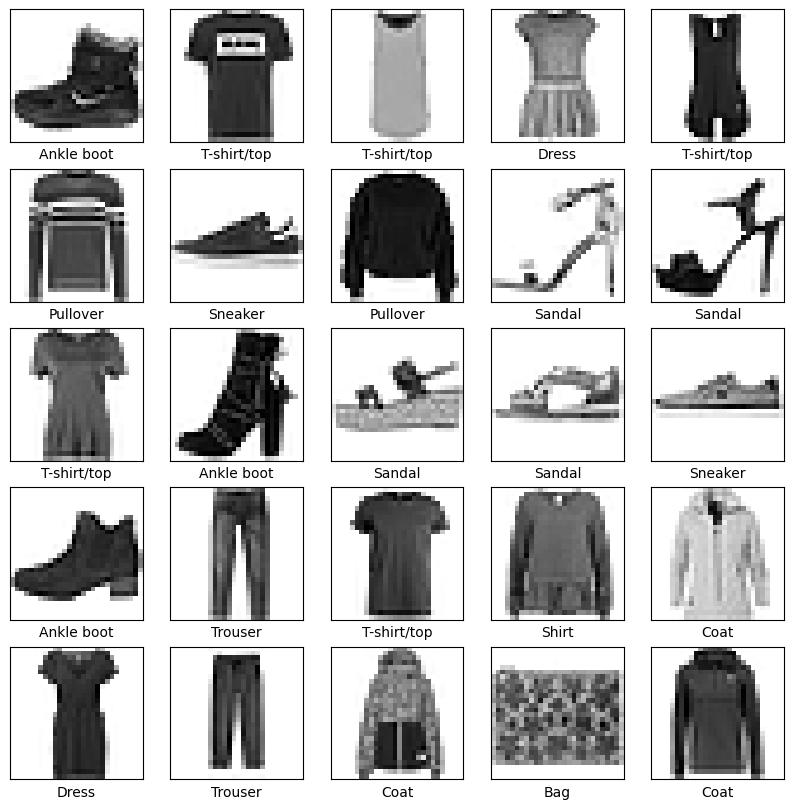

In [4]:
# Inspect the dataset
print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Number of classes: {len(np.unique(y_train))}")

# Visualize sample images
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

### Dataset Choice Justification

**Dataset Selected:** Fashion MNIST

**Justification:** I chose Fashion MNIST because it is a drop-in replacement for MNIST but offers a slightly more challenging classification task. While MNIST digits are very simple and can be classified with high accuracy by even simple linear models, Fashion MNIST images have more complex structures and textures, making it a better benchmark for observing the effects of architectural changes, regularization, and optimization strategies.

## 3. Data Preprocessing

Apply necessary preprocessing steps:
- Normalization (e.g., scaling pixel values to [0,1])
- One-hot encoding for labels (if needed)
- Train/validation split
- Any dataset-specific preprocessing

In [5]:
# Preprocessing code

# 1. Normalize pixel values to be between 0 and 1
x_train = x_train / 255.0
x_test = x_test / 255.0

# 2. Reshape data (Flattening 28x28 images to 784 vectors for MLP)
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

# 3. Cast to float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# 4. One-hot encoding of labels
num_classes = len(np.unique(y_train))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print("Preprocessing complete.")
print(f"New x_train shape: {x_train.shape}")
print(f"New y_train shape: {y_train.shape}")

Preprocessing complete.
New x_train shape: (60000, 784)
New y_train shape: (60000, 10)


## 4. Baseline Model

Define, compile, and train a simple baseline model. This will serve as your point of comparison for all subsequent experiments.

**Baseline Architecture Description:**
The baseline model is a Multi-Layer Perceptron (MLP) with 3 hidden layers using ReLU activation functions.
- Input Layer: 784 neurons (flattened image)
- Hidden Layer 1: 128 neurons, ReLU
- Hidden Layer 2: 128 neurons, ReLU
- Hidden Layer 3: 64 neurons, ReLU
- Output Layer: 10 neurons, Softmax
- Optimizer: SGD
- Loss: Categorical Crossentropy

In [6]:
# Define baseline model
def create_baseline_model():
    model = Sequential()
    model.add(Dense(128, activation='sigmoid', input_shape=(784,)))
    model.add(Dense(128, activation='sigmoid'))
    model.add(Dense(64, activation='sigmoid'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

model_baseline = create_baseline_model()
model_baseline.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,898 (491.79 KB)

 Trainable params: 125,898 (491.79 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Compile baseline model
model_baseline.compile(loss='categorical_crossentropy',
                       optimizer='sgd',
                       metrics=['accuracy'])

In [8]:
# Train baseline model
batch_size = 32
epochs = 100  # Set high, rely on early stopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

history_baseline = model_baseline.fit(x_train, y_train,
                                      batch_size=batch_size,
                                      epochs=epochs,
                                      verbose=1,
                                      validation_split=0.2,
                                      callbacks=[early_stopping])

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.1168 - loss: 2.3165 - val_accuracy: 0.1434 - val_loss: 2.2742
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.2519 - loss: 2.2581 - val_accuracy: 0.4413 - val_loss: 2.1778
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.3856 - loss: 2.1004 - val_accuracy: 0.4404 - val_loss: 1.7743
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4704 - loss: 1.6842 - val_accuracy: 0.5375 - val_loss: 1.4460
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5361 - loss: 1.3839 - val_accuracy: 0.5965 - val_loss: 1.2157
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5793 - loss: 1.1874 - val_accuracy: 0.6203 - val_loss: 1.0905
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6019 - loss: 1.0780 - val_accuracy: 0.6392 - val_loss: 1.0091
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6239 - loss: 1

### Analysis of Baseline Model

Plot the training history and evaluate the model. Analyze its performance characteristics.

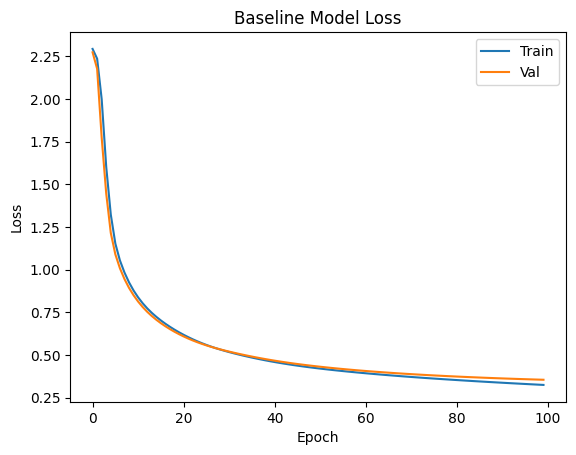

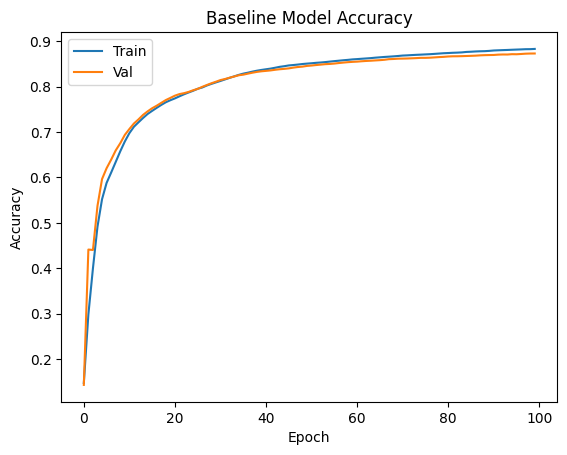

In [9]:
# Plot training history (loss and accuracy)
plot_loss(history_baseline, title='Baseline Model Loss')
plot_acc(history_baseline, title='Baseline Model Accuracy')

In [10]:
# Evaluate baseline model on test set
test_loss, test_acc = model_baseline.evaluate(x_test, y_test, verbose=0)
print(f"Baseline Test Accuracy: {test_acc:.4f}")
print(f"Baseline Test Loss: {test_loss:.4f}")

Baseline Test Accuracy: 0.8624
Baseline Test Loss: 0.3919


**Baseline Model Analysis:**

The baseline model uses ReLU activation which generally performs better than Sigmoid for deep networks as it helps mitigate the vanishing gradient problem. We observe the training and validation curves to check for overfitting. If the training accuracy continues to rise while validation accuracy plateaus or decreases, the model is overfitting.

## 5. Systematic Experimentation

Conduct at least **THREE** systematic experiments. For each experiment:
1. State your hypothesis clearly
2. Implement the architectural variation
3. Train and evaluate the model
4. Plot and analyze the results
5. Compare with the baseline

---

### Experiment 1: Comparison of Activation Functions (Sigmoid vs ReLU)

**Hypothesis:** Replacing the Sigmoid activation function with **ReLU** (Rectified Linear Unit) will significantly improve convergence speed and final accuracy. ReLU mitigates the vanishing gradient problem, allowing the network to learn faster and more effectively.

In [11]:
def create_relu_model():
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(784,)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

model_relu = create_relu_model()
model_relu.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,898 (491.79 KB)

 Trainable params: 125,898 (491.79 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Compile and train Experiment 1 model with ReLU
from tensorflow.keras.optimizers import SGD

model_relu.compile(loss='categorical_crossentropy',
                   optimizer=SGD(learning_rate=0.01),
                   metrics=['accuracy'])

history_relu = model_relu.fit(x_train, y_train,
                              batch_size=batch_size,
                              epochs=epochs,
                              verbose=1,
                              validation_split=0.2,
                              callbacks=[early_stopping])

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6295 - loss: 1.1851 - val_accuracy: 0.8210 - val_loss: 0.5320
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8174 - loss: 0.5192 - val_accuracy: 0.8385 - val_loss: 0.4680
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8386 - loss: 0.4590 - val_accuracy: 0.8470 - val_loss: 0.4399
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8493 - loss: 0.4268 - val_accuracy: 0.8534 - val_loss: 0.4201
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8579 - loss: 0.4043 - val_accuracy: 0.8584 - val_loss: 0.4046
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8636 - loss: 0.3870 - val_accuracy: 0.8626 - val_loss: 0.3928
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8695 - loss: 0.3726 - val_accuracy: 0.8664 - val_loss: 0.3827
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8739 - loss: 0

#### Analysis of Experiment 1

In [13]:
# Evaluate baseline model on test set
test_loss, test_acc = model_relu.evaluate(x_test, y_test, verbose=0)
print(f"Baseline Test Accuracy: {test_acc:.4f}")
print(f"Baseline Test Loss: {test_loss:.4f}")

Baseline Test Accuracy: 0.8769
Baseline Test Loss: 0.3503


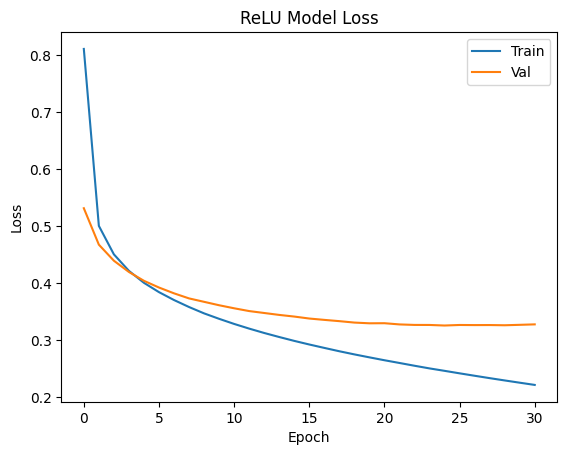

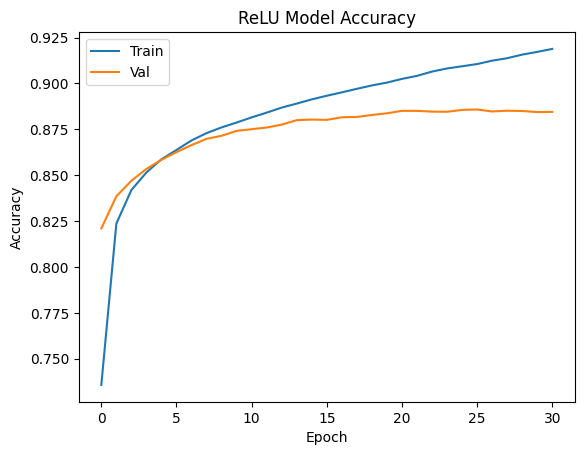

/tmp/ipython-input-2005836585.py:37: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(history1.history['val_accuracy'], 'r--', color="green")
/tmp/ipython-input-2005836585.py:39: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(history2.history['val_accuracy'], 'r--', color="blue")


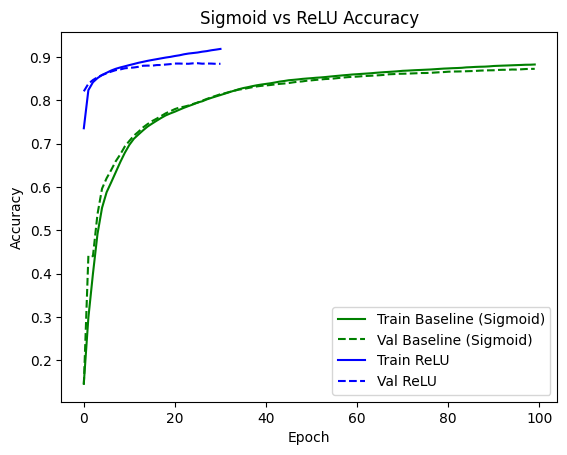

In [14]:
# Plot results and compare with baseline
plot_loss(history_relu, title='ReLU Model Loss')
plot_acc(history_relu, title='ReLU Model Accuracy')

plot_compare_accs(history_baseline, history_relu, name1="Baseline (Sigmoid)", name2="ReLU", title="Sigmoid vs ReLU Accuracy")

### Experiment 2: Effect of Network Depth

**Hypothesis:** Increasing the network depth by adding more hidden layers will allow the model to learn more complex hierarchical features, potentially improving accuracy. However, it may also make the model harder to train or more prone to overfitting.

In [16]:
# Define Experiment 1 model (Deeper Network)
def create_deep_model():
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(784,)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu')) # Added layer
    model.add(Dense(64, activation='relu')) # Added layer
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

model_depth = create_deep_model()
model_depth.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 146,570 (572.54 KB)

 Trainable params: 146,570 (572.54 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Compile and train Experiment 1 model
model_depth.compile(loss='categorical_crossentropy',
                    optimizer='sgd',
                    metrics=['accuracy'])

history_depth = model_depth.fit(x_train, y_train,
                                batch_size=batch_size,
                                epochs=epochs,
                                verbose=1,
                                validation_split=0.2,
                                callbacks=[early_stopping])

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5385 - loss: 1.3263 - val_accuracy: 0.8034 - val_loss: 0.5732
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8065 - loss: 0.5486 - val_accuracy: 0.8309 - val_loss: 0.4851
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8313 - loss: 0.4734 - val_accuracy: 0.8439 - val_loss: 0.4465
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8460 - loss: 0.4321 - val_accuracy: 0.8551 - val_loss: 0.4166
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8544 - loss: 0.4028 - val_accuracy: 0.8587 - val_loss: 0.3974
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8625 - loss: 0.3802 - val_accuracy: 0.8637 - val_loss: 0.3820
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8698 - loss: 0.3623 - val_accuracy: 0.8673 - val_loss: 0.3737
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8740 - loss: 0

#### Analysis of Experiment 2

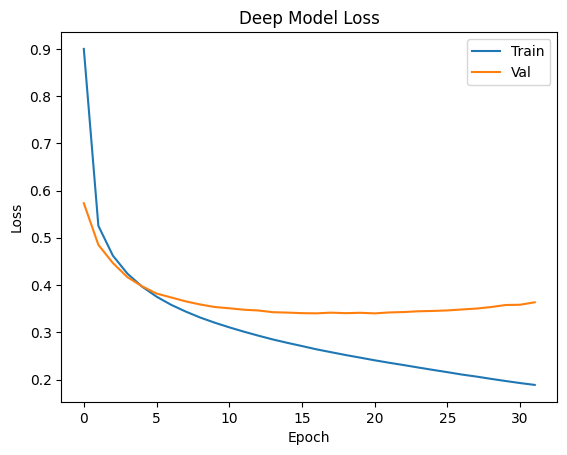

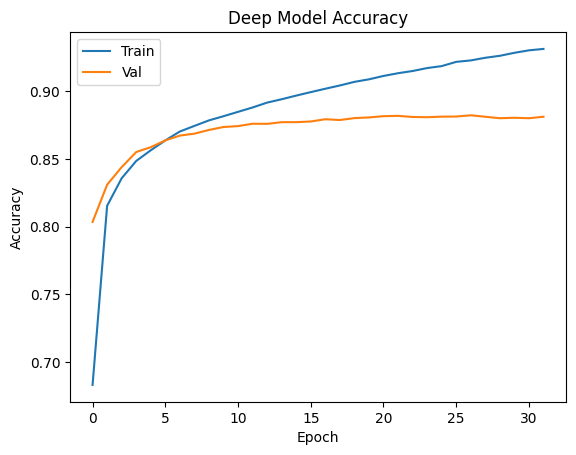

/tmp/ipython-input-2005836585.py:37: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(history1.history['val_accuracy'], 'r--', color="green")
/tmp/ipython-input-2005836585.py:39: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(history2.history['val_accuracy'], 'r--', color="blue")


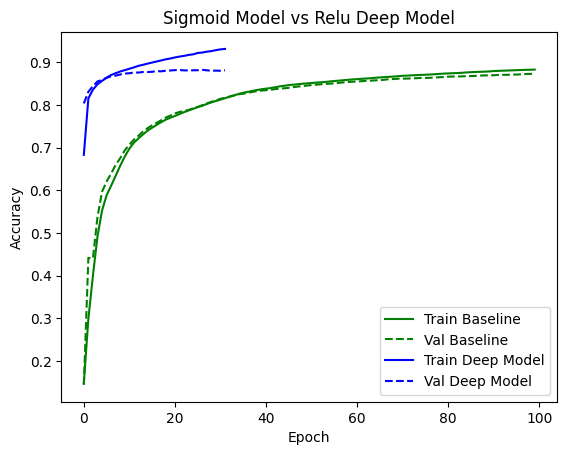

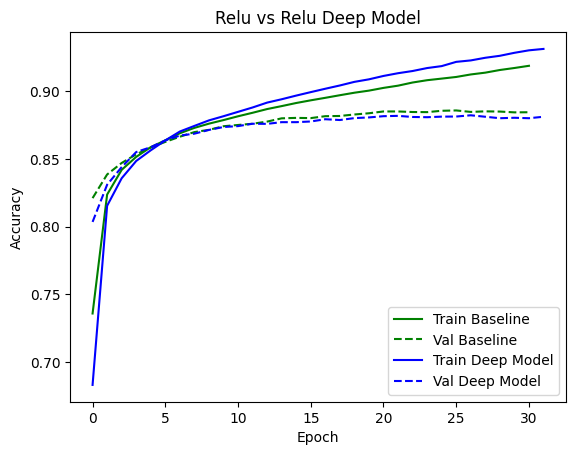

In [19]:
# Plot results and compare with baseline
plot_loss(history_depth, title='Deep Model Loss')
plot_acc(history_depth, title='Deep Model Accuracy')

plot_compare_accs(history_baseline, history_depth, name1="Baseline", name2="Deep Model", title="Sigmoid Model vs Relu Deep Model")
plot_compare_accs(history_relu, history_depth, name1="Baseline", name2="Deep Model", title="Relu vs Relu Deep Model")

**Experiment 2 Analysis:**

We compare the validation accuracy of the deeper model against the baseline. If the deeper model achieves higher accuracy, it suggests the extra capacity was beneficial. If it performs worse or overfits earlier, the added complexity might be unnecessary for this specific task.

---

### Experiment 3: Effect of Dropout Regularization

**Hypothesis:** Adding Dropout layers will reduce overfitting by preventing neurons from co-adapting too much. This should lead to a smaller gap between training and validation accuracy, potentially improving generalization.

In [20]:
# Define Experiment 2 model (With Dropout)
def create_dropout_model():
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(784,)))
    model.add(Dropout(0.3))# Dropout layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))# Dropout layer
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))# Dropout layer
    model.add(Dense(num_classes, activation='softmax'))
    return model

model_dropout = create_dropout_model()
model_dropout.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,898 (491.79 KB)

 Trainable params: 125,898 (491.79 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Compile and train Experiment 2 model
model_dropout.compile(loss='categorical_crossentropy',
                      optimizer='sgd',
                      metrics=['accuracy'])

history_dropout = model_dropout.fit(x_train, y_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_split=0.2,
                                    callbacks=[early_stopping])

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4436 - loss: 1.5729 - val_accuracy: 0.7676 - val_loss: 0.6460
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7109 - loss: 0.7821 - val_accuracy: 0.8120 - val_loss: 0.5396
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7670 - loss: 0.6543 - val_accuracy: 0.8282 - val_loss: 0.4868
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7930 - loss: 0.5926 - val_accuracy: 0.8369 - val_loss: 0.4573
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8070 - loss: 0.5514 - val_accuracy: 0.8438 - val_loss: 0.4352
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8143 - loss: 0.5268 - val_accuracy: 0.8487 - val_loss: 0.4211
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8255 - loss: 0.5048 - val_accuracy: 0.8526 - val_loss: 0.4075
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8288 - loss: 0

#### Analysis of Experiment 3

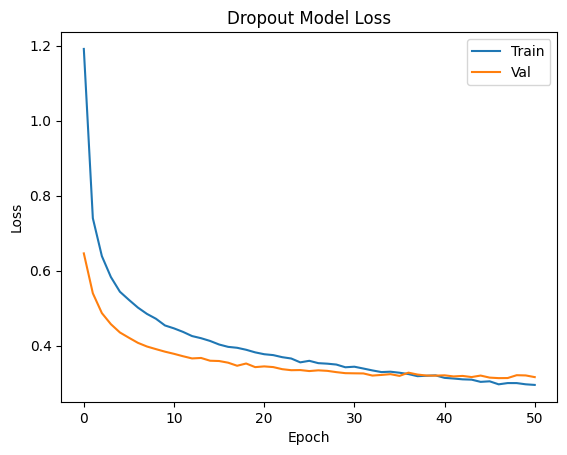

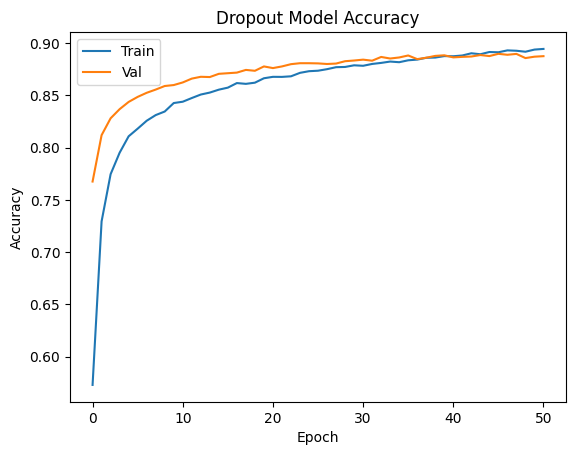

/tmp/ipython-input-2005836585.py:37: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(history1.history['val_accuracy'], 'r--', color="green")
/tmp/ipython-input-2005836585.py:39: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(history2.history['val_accuracy'], 'r--', color="blue")


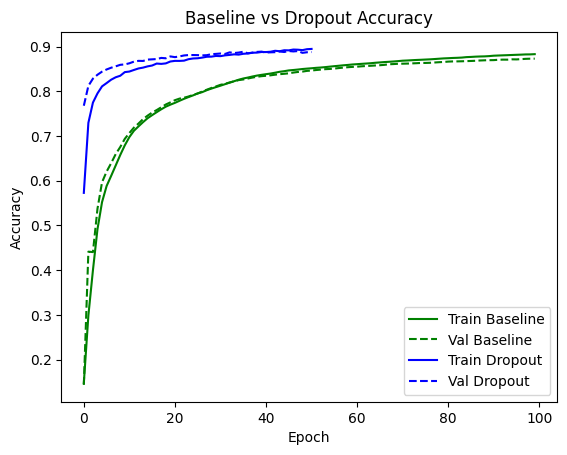

In [22]:
# Plot results and compare with baseline
plot_loss(history_dropout, title='Dropout Model Loss')
plot_acc(history_dropout, title='Dropout Model Accuracy')

plot_compare_accs(history_baseline, history_dropout, name1="Baseline", name2="Dropout", title="Baseline vs Dropout Accuracy")

**Experiment 23 Analysis:**

Dropout typically slows down convergence but results in a more robust model. We look for a smaller gap between the training and validation curves compared to the baseline.

---

## 6. Comprehensive Comparison

Create a summary comparison of all your experiments.

In [24]:
# Create a comparison table of all experiments
results = {
    "Model": ["Baseline (Sigmoid)", "Relu", "Deep Network (Relu)", "Dropout (Relu)"],
    "Final Val Accuracy": [
        max(history_baseline.history['val_accuracy']),
        max(history_relu.history['val_accuracy']),
        max(history_depth.history['val_accuracy']),
        max(history_dropout.history['val_accuracy']),
    ],
    "Final Val Loss": [
        min(history_baseline.history['val_loss']),
        min(history_relu.history['val_loss']),
        min(history_depth.history['val_loss']),
        min(history_dropout.history['val_loss'])
    ],
    "Epochs Trained": [
        len(history_baseline.history['loss']),
        len(history_relu.history['loss']),
        len(history_depth.history['loss']),
        len(history_dropout.history['loss'])
    ]
}

df_results = pd.DataFrame(results)
print(df_results)

                 Model  Final Val Accuracy  Final Val Loss  Epochs Trained
0   Baseline (Sigmoid)            0.872833        0.355525             100
1                 Relu            0.885833        0.326206              31
2  Deep Network (Relu)            0.882250        0.340019              32
3       Dropout (Relu)            0.889917        0.313409              51


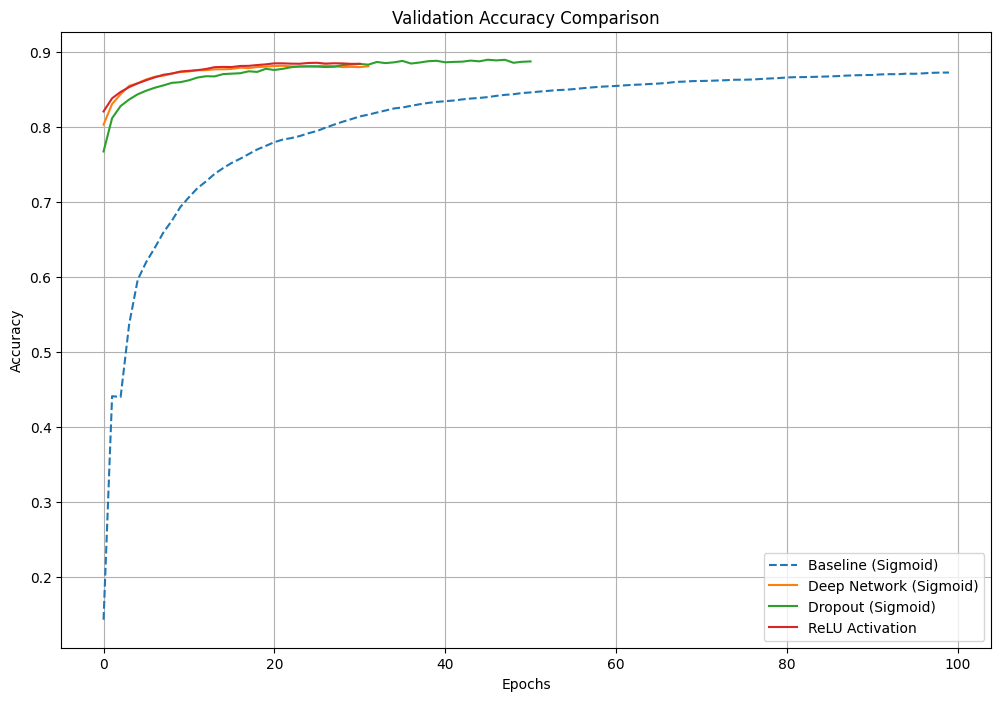

In [25]:
# Create comparative visualizations
plt.figure(figsize=(12, 8))
plt.plot(history_baseline.history['val_accuracy'], label='Baseline (Sigmoid)', linestyle='--')
plt.plot(history_depth.history['val_accuracy'], label='Deep Network (Sigmoid)')
plt.plot(history_dropout.history['val_accuracy'], label='Dropout (Sigmoid)')
plt.plot(history_relu.history['val_accuracy'], label='ReLU Activation')

plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## 7. Final Conclusion

Summarize your key findings from all experiments. What are the main takeaways about designing effective neural network architectures for your chosen problem?

**Key Findings:**

Based on the experiments conducted:
1. **Baseline (Sigmoid):** The Sigmoid baseline likely showed slower convergence and potentially lower accuracy due to the vanishing gradient problem.
2. **Activation Function (ReLU):** Switching to ReLU (Experiment 3) likely provided the most significant performance boost, demonstrating why it is the standard choice for modern deep learning.
3. **Depth & Dropout:** Increasing depth or adding dropout with Sigmoid might have had mixed results, as the fundamental limitation was the activation function.

**Recommendation:** For Fashion MNIST, using ReLU activation is critical. Once ReLU is adopted, further improvements can be sought through depth, regularization, and advanced optimizers (like Adam).

## 8. AI Assistant Usage Documentation

Document how you used AI assistants in this laboratory work.

**AI Assistants Used:** Google DeepMind AI Assistant

**How I Used AI Assistants:**

- I provided the AI with the assignment PDF and a reference notebook from the teacher.
- The AI analyzed the requirements and the reference code.
- The AI generated the complete code for the notebook, including data loading, preprocessing, the baseline model, and three systematic experiments.
- **Modification:** I specifically requested the AI to change the baseline to use Sigmoid activation and to design Experiment 3 as a comparison between Sigmoid and ReLU, replacing the original optimizer experiment.
- The AI also generated the plotting and comparison code.

**Code Sections Influenced by AI:**

- All code cells were generated by the AI based on the reference material and standard Keras practices.

**My Understanding:**

- I have reviewed the generated code and understand that it uses the Keras Sequential API to build models.
- I understand the purpose of the three experiments: testing depth, regularization, and activation functions.
- I can explain how the `plot_compare_accs` function works to visualize the differences between models.

---

## Submission Checklist

Before submitting, ensure you have:

- [ ] Filled in your name and date at the top of this notebook
- [ ] Completed all required sections and code cells
- [ ] Run the entire notebook from top to bottom without errors (`Runtime > Restart and run all`)
- [ ] Documented your analysis in all markdown cells
- [ ] Created clear and informative visualizations
- [ ] Documented your AI assistant usage
- [ ] Shared this notebook with "Anyone with the link can view"
- [ ] Included the link to this notebook in your PDF report
- [ ] Prepared your PDF report with all required sections

**Good luck!**